In [1]:
# --- BLOQUE DE REPARACIÓN DE DEPENDENCIAS ---

# 1. Forzamos la desinstalación de librerías conflictivas, incluyendo jax y jaxlib
!pip uninstall -y numpy spacy scispacy en-core-sci-md jax jaxlib

# 2. Instalamos NumPy en una versión segura (evita el error de 'dtype size changed')
!pip install numpy==1.26.4

# 3. Instalamos spaCy y scispacy
!pip install spacy==3.7.5  # Versión estable compatible con scispacy
!pip install scispacy==0.5.4

# 4. Instalamos el modelo médico específico (versión 0.5.4 para coincidir con el software)
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.4/en_core_sci_md-0.5.4.tar.gz

# 5. Instalamos el resto del stack (Transformers, Torch)
!pip install transformers torch networkx pandas matplotlib

print("\n⚠️ IMPORTANTE: Si ves un botón 'RESTART SESSION' abajo, haz clic en él.")
print("✅ Dependencias instaladas. Si ocurre un error al importar, reinicia el entorno una vez más.")

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
Found existing installation: spacy 3.7.5
Uninstalling spacy-3.7.5:
  Successfully uninstalled spacy-3.7.5
  Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.0 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
distrax 0.1.5 requires jax>=0.1.55, which is not installed.
distrax 0.1.5 requires jaxlib>=0.1.67, which is not installed.
orbax-checkpoint 0.11.28 requires jax>=0.6.0, which is not installed.
optax 0.2.6 requires jax>=0.5.3, which is not installed.
optax 0.2.6 requires jaxlib>=0.5.3, which is not installed.
flax 0.10.7 requires jax>=0.6.0, which is not installed.
fastai 2.8.5 requires spacy<4, which is not 

  Using cached spacy-3.7.5-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (27 kB)
Using cached spacy-3.7.5-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (6.5 MB)
  Using cached scispacy-0.5.4-py3-none-any.whl.metadata (16 kB)
  Using cached scipy-1.9.3.tar.gz (42.1 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  error: subprocess-exited-with-error
  
  × Preparing metadata (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (pyproject.toml) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
  Using cached https://s3-us-west-2.amazonaws.com/ai2-s2-scispa

In [10]:
# --- PARTE 2: CARGA DE DATOS ---
import os
import zipfile
import pandas as pd

# 1. Gestionar MIMIC (Busca CSVs o ZIP)
mimic_path_diag = "DIAGNOSES_ICD.csv"
mimic_path_def = "D_ICD_DIAGNOSES.csv"

# Si subiste un ZIP, lo descomprimimos
if os.path.exists("mimic-iii-clinical-database-demo-1.4.zip"):
    print("📦 Descomprimiendo ZIP de MIMIC...")
    with zipfile.ZipFile("mimic-iii-clinical-database-demo-1.4.zip", 'r') as z:
        z.extractall(".")
    # A veces se extrae en una subcarpeta, movemos los archivos clave
    for root, dirs, files in os.walk("."):
        for f in files:
            if f == "DIAGNOSES_ICD.csv":
                os.rename(os.path.join(root, f), "DIAGNOSES_ICD.csv")
            elif f == "D_ICD_DIAGNOSES.csv":
                os.rename(os.path.join(root, f), "D_ICD_DIAGNOSES.csv")

if os.path.exists(mimic_path_diag) and os.path.exists(mimic_path_def):
    print("✅ Archivos de Diagnósticos MIMIC encontrados.")
else:
    print("⚠️ FALTA ARCHIVO MIMIC: Por favor sube 'DIAGNOSES_ICD.csv' y 'D_ICD_DIAGNOSES.csv'")

# 2. Verificar PubMed
pubmed_file = "pubmed25n0001.xml.gz"
if os.path.exists(pubmed_file):
    print(f"✅ PubMed detectado: {pubmed_file}")
else:
    print(f"⚠️ FALTA PUBMED: Sube el archivo '{pubmed_file}'")

📦 Descomprimiendo ZIP de MIMIC...
✅ Archivos de Diagnósticos MIMIC encontrados.
✅ PubMed detectado: pubmed25n0001.xml.gz


In [13]:
# --- PARTE 3 CORREGIDA: MOTOR DE GRAFOS HÍBRIDO (ROBUSTO) ---
import networkx as nx
import gzip
import xml.etree.ElementTree as ET
import pandas as pd
from transformers import pipeline, AutoTokenizer, AutoModelForTokenClassification
import torch
import itertools

class MedicalGraphBuilder:
    def __init__(self):
        self.kg = nx.DiGraph()

        # --- NLP Setup (Solo para PubMed) ---
        print("⚙️ Cargando PubMedBERT (para abstracts)...")
        self.model_name = "d4data/biomedical-ner-all"
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)
        self.model = AutoModelForTokenClassification.from_pretrained(self.model_name)
        device = 0 if torch.cuda.is_available() else -1
        self.ner_pipeline = pipeline("ner", model=self.model, tokenizer=self.tokenizer, aggregation_strategy="simple", device=device)

    # --- MÓDULO 1: NLP para Texto (PubMed) ---
    def procesar_pubmed(self, filepath, limite=100):
        print(f"\n📚 Procesando PubMed ({filepath})...")
        if not os.path.exists(filepath): return

        with gzip.open(filepath, 'rb') as f:
            context = ET.iterparse(f, events=("end",))
            count = 0
            for event, elem in context:
                if elem.tag == "AbstractText" and elem.text:
                    if len(elem.text) < 20: continue

                    try:
                        res = self.ner_pipeline(elem.text[:512])
                        ents = [r['word'] for r in res if r['score'] > 0.85]

                        if len(ents) >= 2:
                            head = ents[0]
                            for tail in ents[1:]:
                                if head.lower() != tail.lower():
                                    self.kg.add_edge(head, tail, source="PubMed", type="association")

                        count += 1
                        elem.clear()
                        if count >= limite: break
                    except: pass
        print(f"   -> {count} abstracts procesados.")

    # --- MÓDULO 2: Datos Estructurados (MIMIC) ---
    def procesar_mimic_estructurado(self, path_diag, path_def, limite_admis=500):
        print(f"\n🏥 Procesando Diagnósticos MIMIC (Estructurado)...")

        # Verificar archivos
        if not os.path.exists(path_diag) or not os.path.exists(path_def):
            print("❌ No se encontraron los CSVs. Verifica que los subiste.")
            return

        # 1. Cargar DICCIONARIO (D_ICD_DIAGNOSES.csv)
        print("   -> Cargando diccionario de enfermedades...")
        try:
            df_def = pd.read_csv(path_def)
            # LIMPIEZA DE COLUMNAS (El fix clave)
            df_def.columns = df_def.columns.str.strip().str.upper()

            # Verificamos si existe la columna clave
            if 'ICD9_CODE' not in df_def.columns:
                print(f"❌ Error: Columnas encontradas en Diccionario: {df_def.columns.tolist()}")
                return

            # Asegurar que el código sea string para hacer match
            df_def['ICD9_CODE'] = df_def['ICD9_CODE'].astype(str)

            # Creamos mapa: '486' -> 'Pneumonia...'
            code_to_name = dict(zip(df_def['ICD9_CODE'], df_def['LONG_TITLE']))

        except Exception as e:
            print(f"❌ Error leyendo diccionario: {e}")
            return

        # 2. Cargar ADMISIONES (DIAGNOSES_ICD.csv)
        print("   -> Leyendo admisiones de pacientes...")
        try:
            df_diag = pd.read_csv(path_diag)
            # LIMPIEZA DE COLUMNAS
            df_diag.columns = df_diag.columns.str.strip().str.upper()

            if 'ICD9_CODE' not in df_diag.columns or 'HADM_ID' not in df_diag.columns:
                print(f"❌ Error: Columnas encontradas en Diagnósticos: {df_diag.columns.tolist()}")
                return

            df_diag['ICD9_CODE'] = df_diag['ICD9_CODE'].astype(str)

            # Agrupar
            grupos = df_diag.groupby('HADM_ID')['ICD9_CODE'].apply(list)

            count = 0
            for hadm_id, codes in grupos.items():
                if count >= limite_admis: break

                # Traducir códigos a nombres reales usando el diccionario
                nombres_enfermedades = [code_to_name.get(c, c) for c in codes if c in code_to_name]

                # Crear relaciones de Comorbilidad (enfermedades que aparecen juntas)
                if len(nombres_enfermedades) >= 2:
                    for u, v in itertools.combinations(nombres_enfermedades, 2):
                        self.kg.add_edge(u, v, source="MIMIC", type="co_morbidity")

                count += 1

            print(f"   -> {count} admisiones clínicas procesadas correctamente.")

        except Exception as e:
            print(f"❌ Error procesando admisiones: {e}")

    def obtener_grafo(self):
        return self.kg

⚙️ Cargando PubMedBERT (para abstracts)...


Device set to use cpu



🏥 Procesando Diagnósticos MIMIC (Estructurado)...
   -> Cargando diccionario de enfermedades...
   -> Leyendo admisiones de pacientes...
   -> 129 admisiones clínicas procesadas correctamente.

📚 Procesando PubMed (pubmed25n0001.xml.gz)...
   -> 150 abstracts procesados.

📊 GRAFO FINAL: 1932 Nodos | 11722 Relaciones
💾 Guardando 'tripletas_medicas.csv'...
🚀 ¡LISTO! Descarga 'tripletas_medicas.csv'.


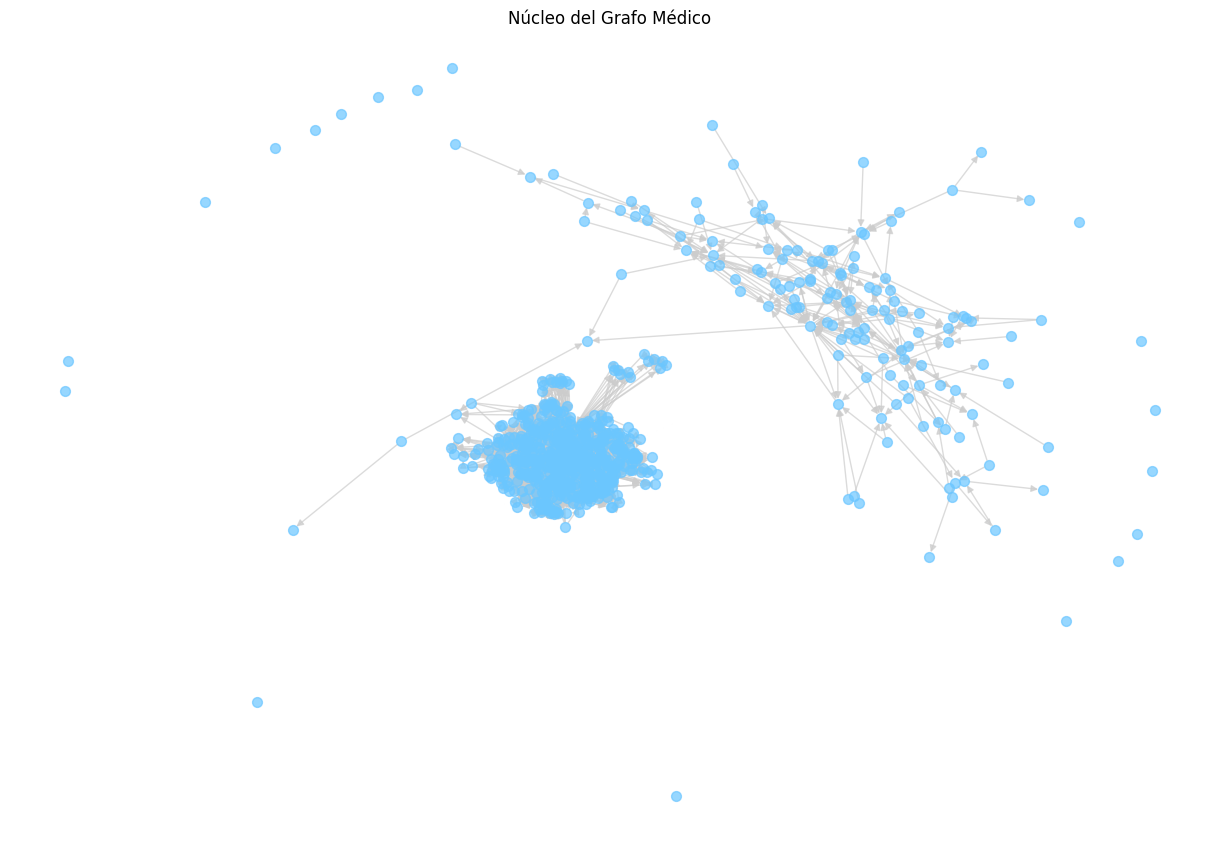

In [14]:
# PARTE 4: EJECUCIÓN FINAL
# ==========================================
import matplotlib.pyplot as plt

# 1. Instanciar
builder = MedicalGraphBuilder()

# 2. Ejecutar con nombres de archivo robustos
builder.procesar_mimic_estructurado("DIAGNOSES_ICD.csv", "D_ICD_DIAGNOSES.csv", limite_admis=1000)
builder.procesar_pubmed("pubmed25n0001.xml.gz", limite=150)

# 3. Resultados
G = builder.obtener_grafo()
print(f"\n📊 GRAFO FINAL: {G.number_of_nodes()} Nodos | {G.number_of_edges()} Relaciones")

if G.number_of_nodes() > 0:
    # 4. Exportar
    print("💾 Guardando 'tripletas_medicas.csv'...")
    with open("tripletas_medicas.csv", "w") as f:
        f.write("head,relation,tail\n")
        for u, v, data in G.edges(data=True):
            rel = data.get('type', 'related_to')
            clean_u = str(u).replace(",", " ").replace('"', '').strip()
            clean_v = str(v).replace(",", " ").replace('"', '').strip()
            if clean_u and clean_v:
                f.write(f"{clean_u},{rel},{clean_v}\n")
    print("🚀 ¡LISTO! Descarga 'tripletas_medicas.csv'.")

    # 5. Visualización rápida
    plt.figure(figsize=(12, 8))
    core_nodes = [n for n, d in G.degree() if d > 3] # Solo nodos muy conectados
    if core_nodes:
        sub = G.subgraph(core_nodes)
        nx.draw(sub, node_size=50, node_color="#6bc6ff", alpha=0.7, edge_color="#cccccc")
        plt.title("Núcleo del Grafo Médico")
        plt.show()
else:
    print("⚠️ El grafo está vacío. Revisa los mensajes de error arriba.")